# Daymet mapping to NHM hrus
This notebook demonstrates the Daymet mapping/interpolating to NHM HRUs

In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
import rasterio
import os
import xarray as xr
import json

Populating the interactive namespace from numpy and matplotlib


# Open Daymet max temperature with geopandas and plot

In [ ]:
print(os.getcwd())
from pathlib import Path
folder = Path(r'../../Data_v1_1') # assumes working directory is onhm-fetcher-parser
print(folder)
# shapefiles = folder.glob("*_0[1-2].shp")
# glob below is not necessary in this case as there is only one shapefile.  Will keep
# code this way as in the case of HRUs split into multiple shapefiles this is how to concatenate
# into one geodataframe

shapefiles = folder.glob("*2e*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
#print(gdf)

In [ ]:
gdf.plot()

# Open Daymet data (as netcdf file) 
https://daymet.ornl.gov/web_services

In [3]:
import requests
from requests.exceptions import HTTPError
from datetime import datetime, timedelta
from urllib.parse import urlencode
from pathlib import Path
testfile = Path('tmax_test3.nc')
if not testfile.exists():
    prcpurl = 'https://thredds.daac.ornl.gov/thredds/ncss/daymet-v3-agg/na.ncml'
    prcppayload = {
    #     'var': 'lat&var=lon&var=tmax',
        'var': 'lat&var=lon&var=prcp&var=srad&var=swe&var=tmax&var=tmin&var=vp',
        'north': '54',
        'west': '-126',
        'east': '-65',
        'south': '20',
        'disableProjSubset': 'on',
        'horizStride': '1',
        'time_start': '2018-12-31T12:00:00Z',
        'time_end': '2018-12-31T12:00:00Z',
        'timeStride': '1',
        'accept': 'netcdf'}    
    try:
        s = requests.Session()
        #https://github.com/psf/requests/issues/1454
        qry = urlencode(prcppayload).replace('%26','&')
        qry = qry.replace('%3D', '=')
        print(qry)
        tmaxfile = requests.get(prcpurl, params=qry)
        tmaxfile.raise_for_status()
    except HTTPError as http_err:
        print(f'HTTP error occured: {http_err}')
    except Exception as err:
        print(f'Other error occured: {err}')
    else:
        print('Daymet data retrieved!')

    with open('tmax_test3.nc', 'wb') as fh:
        fh.write(tmaxfile.content)
    fh.close    

#=========================================================
#            MACAV2METDATA FILE PARAMETERS
#=========================================================
# dirPath='https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1328/2018/daymet_v3_prcp_2018_na.nc4?var=lat&var=lon&var=prcp&north=52.880049298000074+&west=-124.72462483099997+&east=-66.94953853699997+&south=24.839424370000074&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start=2018-12-31T00:00:00Z&time_end=2018-12-31T00:00:00Z&timeStride=1&accept=netcdf'
# fileName='/thredds/dodsC/MET/tmmx/tmmx_2019.nc'
# dirPath = 'tmax_test2.nc'
# dirPath = 'daymet_v3_tmax_2018_na.nc4.nc'
#--------------------------------------------------------
#   FORM FILENAME AND GET HANDLE TO FILE AND DATA
#--------------------------------------------------------
# fullfilename= dirPath
# print(fullfilename)

ds = xr.open_dataset(testfile)

print(ds)

# df = ds.to_dataframe()

print('\n The meta data is: \n', ds.attrs)
lathandle=ds['lat']
lonhandle=ds['lon']
timehandle=ds['time']
datahandle=ds['tmax']
dhlat = ds['lat']
dhlon = ds['lon']
crshandle=ds['lambert_conformal_conic']
print('\n The crs meta data is \n', crshandle.attrs)
print(datahandle)


#collect data to describe geotransform
lonmin = float(ds.attrs['geospatial_lon_min'])
latmax = float(ds.attrs['geospatial_lat_max'])

#Print some information on the data

print('\n Data attributes, sizes, and coords \n') 
print('\n Data attributes are: \n',datahandle.attrs)
print('\n Data sizes are: \n', datahandle.sizes)
print('\n Data coords are: \n', datahandle.coords)
print('\n Lat coords are: \n', dhlat.attrs)

ts = datahandle.sizes
print(type(ts))
print(ts['time'])
dayshape = ts['time']
Lonshape = ts['x']
Latshape = ts['y']
#dayshape,lonshape,latshape = datahandle.values.shape
print(dayshape, Lonshape, Latshape)


var=lat&var=lon&var=prcp&var=srad&var=swe&var=tmax&var=tmin&var=vp&north=54&west=-126&east=-65&south=20&disableProjSubset=on&horizStride=1&time_start=2018-12-31T12%3A00%3A00Z&time_end=2018-12-31T12%3A00%3A00Z&timeStride=1&accept=netcdf
Daymet data retrieved!
<xarray.Dataset>
Dimensions:                  (time: 1, x: 6008, y: 3699)
Coordinates:
  * y                        (y) float32 1687.0 1686.0 ... -2010.0 -2011.0
  * x                        (x) float32 -2754.25 -2753.25 ... 3251.75 3252.75
  * time                     (time) datetime64[ns] 2018-12-31
Data variables:
    lat                      (y, x) float32 ...
    lambert_conformal_conic  int16 ...
    lon                      (y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp           

In [4]:
lon = ds.lon.values
numcells = np.shape(lon)[0]*np.shape(lon)[1]
numcells

22223592

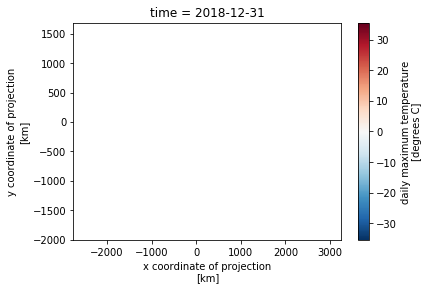

In [5]:
ds.tmax.plot()

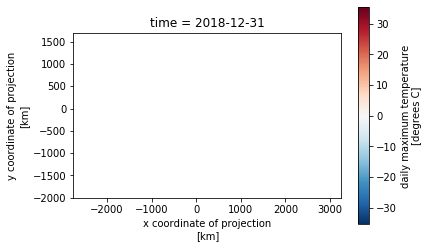

In [10]:
# tmax = ds.tmax.isel(time=[0])
tmax = ds.tmax
# p = tmax.plot(col = 'time', aspect = ds.dims['x']/ds.dims['y'], size = 2)
p = tmax.plot()
p.axes.set_aspect('equal')
plt.show()

In [ ]:
# wght_UofI = pd.read_csv('../pkg/tmp_weights_hru_v1_1.csv')
# print(wght_UofI.head())

# #iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
# ndata = datahandle.values[dayshape-1,:,:].flatten(order='K')

# print(ndata[1000:])

# unique_hru_ids = wght_UofI.groupby('GFv11_id')
# print(len(gdf), len(unique_hru_ids))

In [ ]:
# print(gdf.iloc[0]['GFv11_id'] in unique_hru_ids)

In [ ]:
# # read hru nhm_id that have no intersections
# hru_nointsct = pd.read_csv(r'../Data_v1_1/gridmet_hru_v1_1_nointsct.txt')
# hru_nointsct.head()
# noint = hru_nointsct.hru_nointsct.unique()
# print(type(noint))

In [ ]:
from numpy.ma import masked
# add tmax column to dataframe
gdf['tmax']=0.0
# gdf.tmax[noint] = 10.0
# print(gdf.tmax[noint])

wght_UofI = pd.read_csv('../../Data_v1_1/tmp_daymet_weights_hru_v1_1e.csv')
print(wght_UofI.head())
wghts_id = wght_UofI.columns[1]
print('wghts_id', wghts_id)
#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
# ndata = datahandle.values[dayshape-1,:,:].flatten(order='C')
# ndata = ds.tmax.values[dayshape-1,:,:].flatten()
lon = ds.lon.values
lat = ds.lat.values
ndata = np.zeros(np.shape(lon)[1]*np.shape(lon)[0])
tlc = 0
for i in range(1, np.shape(lon)[0] - 1):
    if i % 100 == 0: print(i, flush=True)
    for j in range(1, np.shape(lon)[1] - 1):
        ndata[tlc] = datahandle.values[dayshape-1,i,j]
        tlc+=1

# print(ndata[1000:])

unique_hru_ids = wght_UofI.groupby(wghts_id)
print(len(gdf), len(unique_hru_ids))

def np_get_wval2(grp, ndata):
    mdata = np.ma.masked_array(ndata[grp['grid_ids'].values.astype(int)], np.isnan(ndata[grp['grid_ids'].values.astype(int)]))
    return np.ma.average(mdata, weights=grp['w'])
def np_get_wval(ndata, wghts, hru_id):
    """
    Returns weighted average of ndata with weights = grp
    1) mdata = the subset of values associated with the gridmet id's that are mapped to hru_id.
    2) Some of these values may have nans if the gridmet id is outside of conus so only return values
    that are inside of conus
    3) this means that hru's that are entirely outside of conus will return nans which will ultimately,
    outside of this function get assigned zero's.
    4) the value is assigned the weighted average
    :param ndata: float array of data values
    :param wghts: float array of weights
    :param hru_id hru id number
    :return: numpy weighted averaged - masked to deal with nans associated with
            ndata that is outside of the conus.
    """
    mdata = np.ma.masked_array(ndata[wghts['grid_ids'].values.astype(int)],
                               np.isnan(ndata[wghts['grid_ids'].values.astype(int)]))

    # mdata = np.ma.masked_where(ndata[wghts['grid_ids'].values.astype(int)] <= 0.0,
    #                            (ndata[wghts['grid_ids'].values.astype(int)]))
    tmp = np.ma.average(mdata, weights=wghts['w'])
    if tmp is masked:
        # print('returning masked value', hru_id, mdata, wghts['w'])
        return np.nan

    else:
        return tmp
    
# unique_hru_ids.get_group(gdf['hru_id_nat']).agg({'tmax': np_get_wval(weight_id_rows, ndata)})    
td = np.zeros(len(gdf.index))
for index, row in gdf.iterrows():
#     if not(row['nhm_id'] in noint):
    try: 
        weight_id_rows = unique_hru_ids.get_group(row[wghts_id])
        td[index] = np.nan_to_num(np_get_wval(ndata, weight_id_rows, index+1))
    except KeyError:
        td[index] = 0.0
            
            
#         gdf['tmax'][index] = np_get_wval2(weight_id_rows, ndata)
#     else:
#         td[index] = 10.0

gdf['tmax'] = td.tolist()
# gdf['tmax'].fillna(0.0)

print('min/max', gdf['tmax'].min(), gdf['tmax'].max())

# f, ax = plt.subplots(2, figsize=(12,12))
# gdf.plot(ax=ax[0], column = 'tmax',linewidth=0., edgecolor='white')
# ax[0].set_aspect('equal')
# ptmax = ds.tmax
# ptmax_1 = ptmax.isel(time=dayshape-1)
# lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)
# ptmax_1.plot(ax=ax[1], levels=lvs, cmap='viridis')

In [ ]:
f, ax = plt.subplots(2, 1)

lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)

ptmax = ds.tmax
ptmax_1 = ptmax.isel(time=dayshape-1)
p=ptmax_1.plot(ax=ax[0], levels=lvs, cmap='viridis')
ax[0].set_aspect('equal', 'box')

g = gdf.plot(ax=ax[1], column = 'tmax',linewidth=0., edgecolor='white', legend=True)
# temp = ds.daily_maximum_temperature[0,:,:]-273.5
ax[1].set_aspect('equal', 'box')


plt.tight_layout()
plt.show()

##### lon = ds.lon.values
lat = ds.lat.values
print(np.shape(lon))

In [ ]:
wght_UofI.head()

In [ ]:
wght_sum = wght_UofI.groupby(wghts_id).sum()
print(type(wght_sum))
wght_sum.head()

In [ ]:
print(wght_sum.head(100))
wght_sum['w'][10000]
wght_sum.w.plot()
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
# print(wght_UofI.loc[wght_UofI['GFv11_id'] == 5])
# tid = 5
# hid = gdf.loc[gdf['GFv11_id']==tid].geometry.area.sum()
# print(hid)

In [ ]:
gdf_id = gdf.groupby('GFv11_id', sort = False)


In [ ]:
# print(gdf_id)
for index, row in gdf_id:
#     print(' ')
    if index < 6:
        print(len(row))
        for geo in row.geometry:
            print(index, row['GFv11_id'].values, geo.area, geo.bounds)
#             print(geo)
#         print(row['GFv11_id'], gdf_id.loc[gdf_id['GFv11_id']==row['GFv11_id']].geometry.area.sum())

In [ ]:
count = 0
for index, row in gdf.iterrows():
    if count < 5:
        print(gdf.loc[[index]])